# Returns Analysis

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta as timedelta

import matplotlib.pyplot as plt

import statsmodels.api as sm

from eod import EodHistoricalData

In [2]:
API_KEY = '' # API Keys for EOD data. Please contact the team if necessary
client = EodHistoricalData(API_KEY)

In [7]:
df = pd.DataFrame()
names = ['ch', 'dbc', 'it', 'rf', 'shel', 'smi', 'wmt']

for n in names:
    tmp = pd.read_excel(f'C:/Users/gobel/code/research_env/USI/financial_modelling/data/{n}.xlsx')
    tmp.set_index(pd.to_datetime(tmp.Date), inplace=True)
    tmp.columns = ['a', 'b']
    df[n] = tmp.b

df.columns = ['ch', 'DBC.US', 'it', 'rf', 'SHEL', 'CSSMI.SW', 'WMT']

In [8]:
eur = pd.DataFrame(client.get_prices_eod('EURUSD.FOREX', period='d', order='a', from_='2010-01-01'))
eur.set_index(pd.to_datetime(eur.date), inplace=True)
df['EUR'] = eur.adjusted_close

chf = pd.DataFrame(client.get_prices_eod('CHFUSD.FOREX', period='d', order='a', from_='2010-01-01'))
chf.set_index(pd.to_datetime(chf.date), inplace=True)
df['CHF'] = chf.adjusted_close

In [9]:
df = df.iloc[::-1]

In [6]:
df = df[:-1]

In [10]:
df.to_csv('full_data.csv')

## Expected Returns

In [33]:
# Load separate 10y data for backtest

tmp = pd.read_csv('data.csv', index_col='date', parse_dates=True)
tmp.drop(['it', 'ch'], axis=1, inplace=True)
tmp.rename({'CHF': 'ch', 'EUR':'it'}, inplace=True, axis=1)
relevant_columns = tmp.columns

In [34]:
spy = pd.DataFrame(client.get_prices_eod('SPY', period='d', order='a', from_='2010-01-01'))
spy.set_index(pd.to_datetime(spy.date), inplace=True)

In [35]:
def capm(returns, market, risk_free=0.01888):
    returns['mkt'] = market
    cov = returns.cov()
    betas = cov["mkt"] / cov.loc["mkt", "mkt"]
    betas = betas.drop("mkt")
    mkt_mean_ret = returns["mkt"].mean() * 252
    return risk_free + betas * (mkt_mean_ret - risk_free)

In [36]:
def mape(actual, forecast):
    return abs((actual - forecast) / actual).mean()

def mae(actual, forecast):
    return abs(actual - forecast).mean()

In [37]:
start = datetime(2013, 1, 1)

In [38]:
ret = tmp.pct_change()

In [39]:
out = {}

current = start
while current < (df.index[-1] - timedelta(years=3)):
    train = ret[:current]
    test = ret[current:current + timedelta(years=3)]
    train_capm = train.mean() * 252
    tmp_capm = capm(train[['WMT', 'SHEL']], spy[['adjusted_close']][:current].pct_change())
    train_capm['WMT'] = tmp_capm['WMT']
    train_capm['SHEL'] = tmp_capm['SHEL']
    out[current] = [
        mae(test.mean() * 252, train.mean() * 252),
        mae(test.mean() * 252, train_capm),
        mae(test.mean() * 252, train.ewm(span=252).mean().iloc[-1] * 252), 
        mae(test.mean() * 252, train.ewm(span=252*3).mean().iloc[-1] * 252),
        mae(test.mean() * 252, train.ewm(span=252*5).mean().iloc[-1] * 252)
        ]
    current += timedelta(months=1)

<ipython-input-35-192f55f1227a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['mkt'] = market
<ipython-input-35-192f55f1227a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns['mkt'] = market
<ipython-input-35-192f55f1227a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

In [40]:
out = pd.DataFrame(out).T
out.columns = ['Mean Return', 'CAPM', 'Exponential Mean Return (1y)', 'Exponential Mean Return (3y)', 'Exponential Mean Return (5y)']

In [41]:
out.mean()

Mean Return                     0.072742
CAPM                            0.074692
Exponential Mean Return (1y)    0.126186
Exponential Mean Return (3y)    0.092227
Exponential Mean Return (5y)    0.084510
dtype: float64

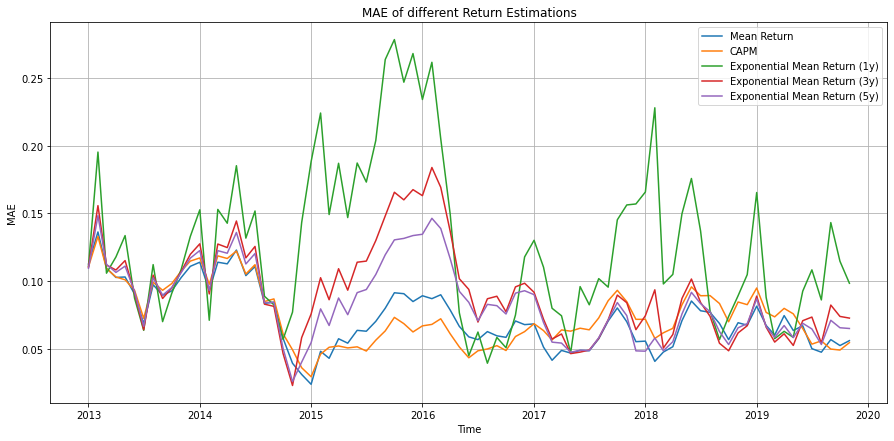

In [42]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

ax.plot(out, label=out.columns)

ax.set_xlabel('Time')
ax.legend()
ax.set_ylabel('MAE')
ax.set_title("MAE of different Return Estimations")
ax.grid()

## Black Litterman

In [45]:
from pypfopt import BlackLittermanModel, risk_models

In [43]:
df = df[:'2022-10-23']
df.tail()

,ch,DBC.US,it,rf,SHEL,CSSMI.SW,WMT,EUR,CHF
Date,,,,,,,,,
2022-10-17,0.660,25.12,3.409,4.469,51.41,108.840,131.42,0.9838,0.9963
2022-10-18,0.629,24.82,3.423,4.465,51.43,109.640,134.19,0.9852,1.0045
2022-10-19,0.683,24.83,3.561,4.599,51.76,108.659,133.73,0.9771,1.0064
2022-10-20,0.700,24.86,3.531,4.684,52.01,108.700,134.05,0.9783,0.9952
2022-10-21,0.674,24.88,3.490,4.543,52.97,108.100,136.81,0.9860,0.9962


In [54]:
ret = df.pct_change()

In [55]:
prior = ret.ewm(span=252*5).mean().iloc[-1] * 252 # Select prior returns based on the ones we defined above
# Force the prior of the bonds to the actual yield -> we hold until maturity
prior['it'] = 0.03349 
prior['ch'] = 0.00639
prior['rf'] = (df.ewm(span=252*5).mean().iloc[-1]).rf / 100
ret['ch'] = ret.CHF
ret['it'] = ret.EUR

In [56]:
drop = ['ch', 'it', 'rf']

ret.drop(drop, axis=1, inplace=True)
cov = risk_models.exp_cov(ret, span=756, returns_data=True)
prior.drop(drop, axis=0, inplace=True)

In [57]:
# Define our views and the confidence in our view
viewdict = {
    # "ch": 0.00639,
    "DBC.US": 0.10,
    # "it": 0.03349,
    "SHEL": 0.10,
    "CSSMI.SW": 0.08,
    "WMT": 0.11,
    "EUR": 0.04,
    "CHF": 0.08
    # "rf": 0.04
}

confidences = [
    # 0.99,
    0.65,
    # 0.99,
    0.65,
    0.7,
    0.75,
    0.75,
    0.75
    # 0.95
]

In [58]:
bl = BlackLittermanModel(cov_matrix=cov, pi=prior, absolute_views=viewdict, view_confidences=confidences, omega="idzorek")

In [59]:
ret_bl = bl.bl_returns()
# Force our Bonds since we know for certain 
ret_bl['it'] = 0.03349
ret_bl['ch'] = 0.00639
prior['it'] = 0.03349
prior['ch'] = 0.00639
viewdict['it'] = 0.03349
viewdict['ch'] = 0.00639

In [60]:
rets_df = pd.DataFrame([prior, pd.Series(viewdict), ret_bl], 
             index=["Prior", "Views", "Posterior"]).T
rets_df.to_csv('expected_returns.csv')

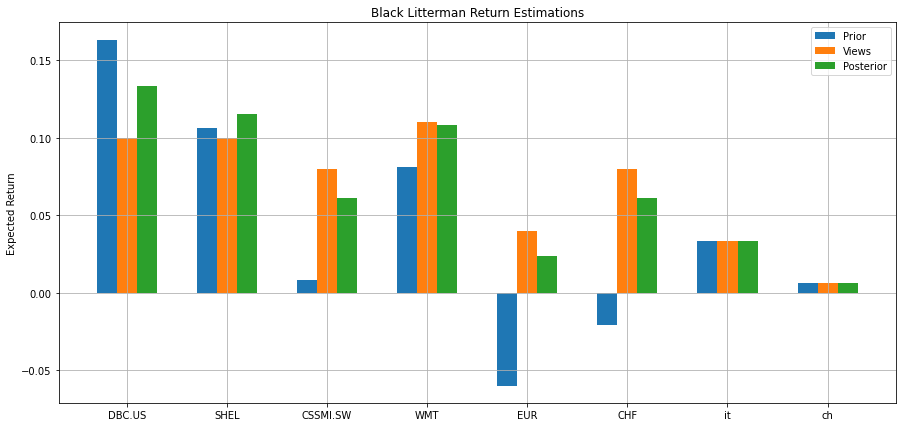

In [61]:
fig, ax = plt.subplots(figsize=(15,7), facecolor='white')

x = np.arange(len(rets_df.index))
width = 0.2

for i in range(len(rets_df.columns)):
    ax.bar(x+width*(i-1), rets_df[rets_df.columns[i]], label=rets_df.columns[i], width=width)

# ax.set_xlabel('Time')
ax.legend()
ax.set_ylabel('Expected Return')
ax.set_xticks(np.arange(len(rets_df.index)), rets_df.index)
ax.set_title("Black Litterman Return Estimations")
ax.grid()